In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

#First model


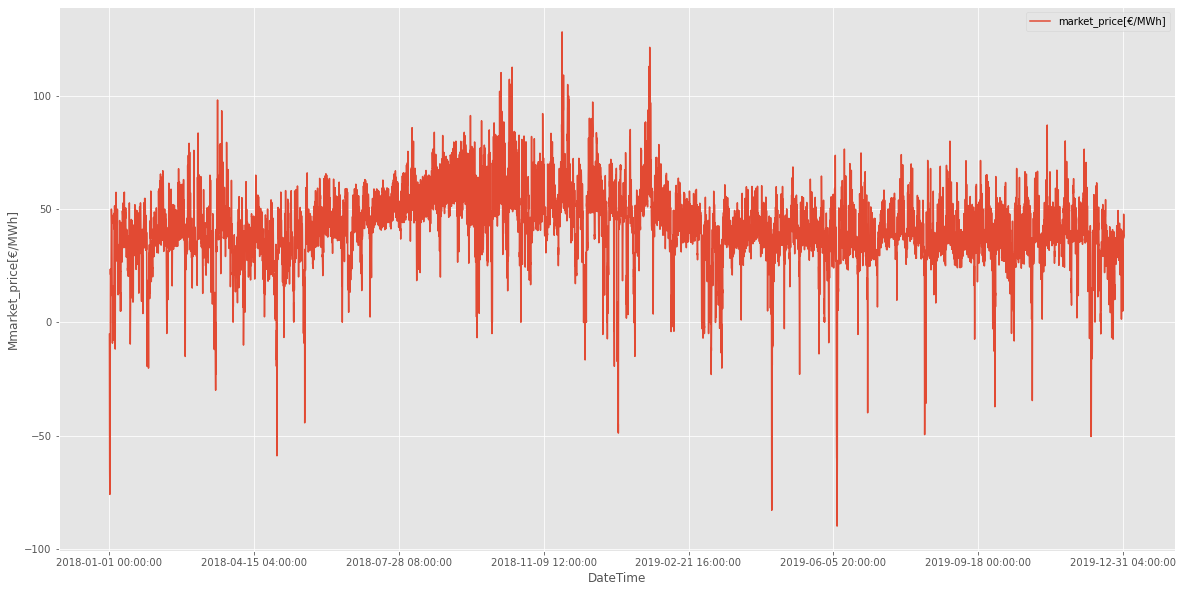

In [2]:
# Load the data
df = pd.read_csv('finaldata.csv')
# A bit of pre-processing to make it nicer
prc_only = df[['DateTime' , 'Price(€/MWh)']]

df['DateTime']=pd.to_datetime(prc_only['DateTime'], format='%Y-%m-%d')
prc_only.set_index(['DateTime'], inplace=True)

# Plot the data
prc_only.plot()
plt.ylabel('Price(€/MWh)')
plt.xlabel('DateTime')
plt.show()

In [3]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [4]:
train_data = prc_only['2018-01-01':'2018-12-30']
test_data = prc_only['2019-01-01':'2019-12-30']

In [5]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])#similar to AIC of ARIMA
        except:
            continue

In [6]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 47987.18136269653 for model SARIMAX(3, 0, 1)x(3, 1, 1, 12)


In [7]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

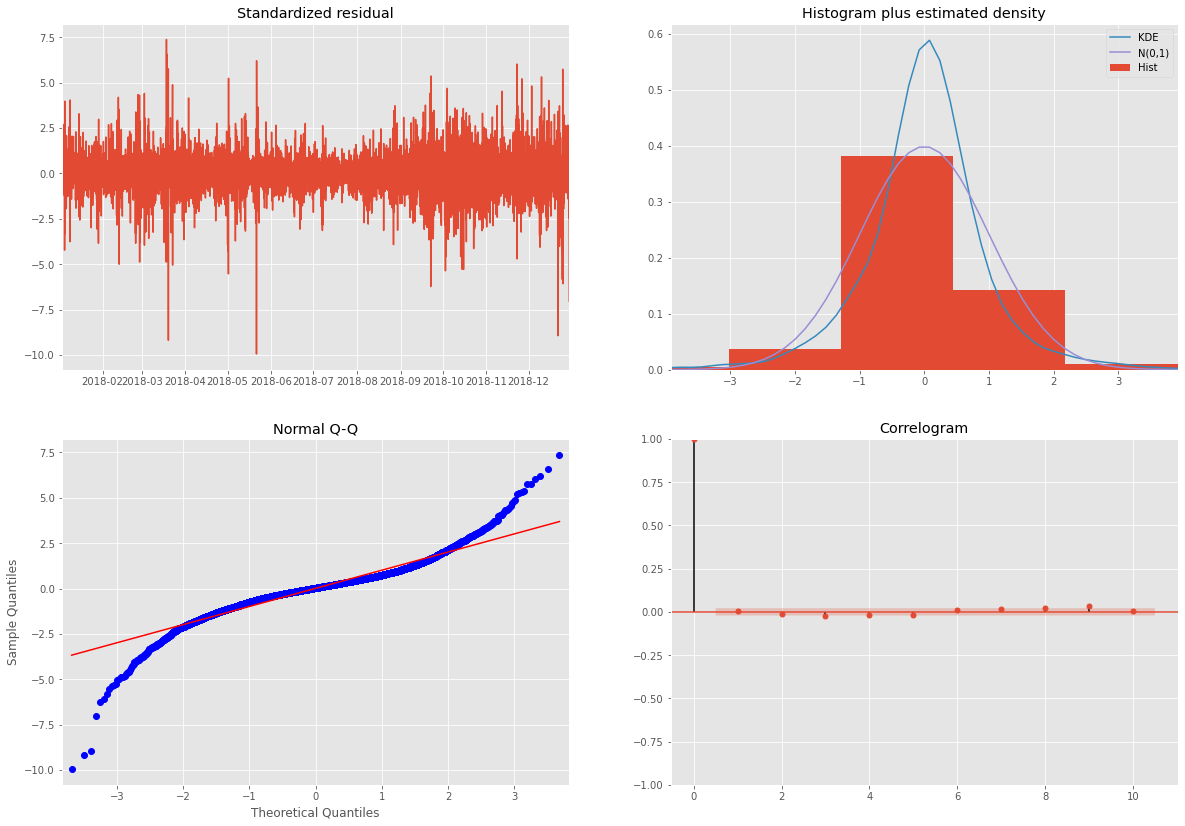

In [8]:
results.plot_diagnostics(figsize=(20, 14)) #this may be useful, diagnostic but you would need to look up the definition of terms
plt.show()

In [12]:
pred0 = results.get_prediction(start='2018-09-01', dynamic=False)#for some reason this wouldnÄt run (type error) maybe KWARG(dynamic has something to do with that)
pred0_ci = pred0.conf_int() #maybe i should have changed the get_prediction to just prediction:i would look into that.

TypeError: '>' not supported between instances of 'int' and 'slice'

In [27]:
pred0 = results.get_forecast('2019-09-01')#, dynamic=False) 
pred0_ci = pred0.conf_int()
print(pred0.predicted_mean['2018-01-01':'2019-12-30'])

2018-12-30 00:00:00    -5.660481
2018-12-30 01:00:00    -7.883575
2018-12-30 02:00:00    -5.370337
2018-12-30 03:00:00    -1.820066
2018-12-30 04:00:00     1.998924
                         ...    
2019-08-31 20:00:00    51.926962
2019-08-31 21:00:00    50.048738
2019-08-31 22:00:00    49.223851
2019-08-31 23:00:00    45.442901
2019-09-01 00:00:00    43.820778
Freq: H, Length: 5881, dtype: float64


In [14]:
pred2 = results.get_forecast('2020-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2019-01-01':'2019-12-30']) #prediction works fine cant verify accuracy

2019-01-01 00:00:00    39.670478
2019-01-01 01:00:00    36.800802
2019-01-01 02:00:00    36.550899
2019-01-01 03:00:00    37.682846
2019-01-01 04:00:00    39.289198
                         ...    
2019-12-30 19:00:00    51.105345
2019-12-30 20:00:00    51.926962
2019-12-30 21:00:00    50.048738
2019-12-30 22:00:00    49.223851
2019-12-30 23:00:00    45.442901
Freq: H, Length: 8736, dtype: float64


NameError: name 'pred0' is not defined

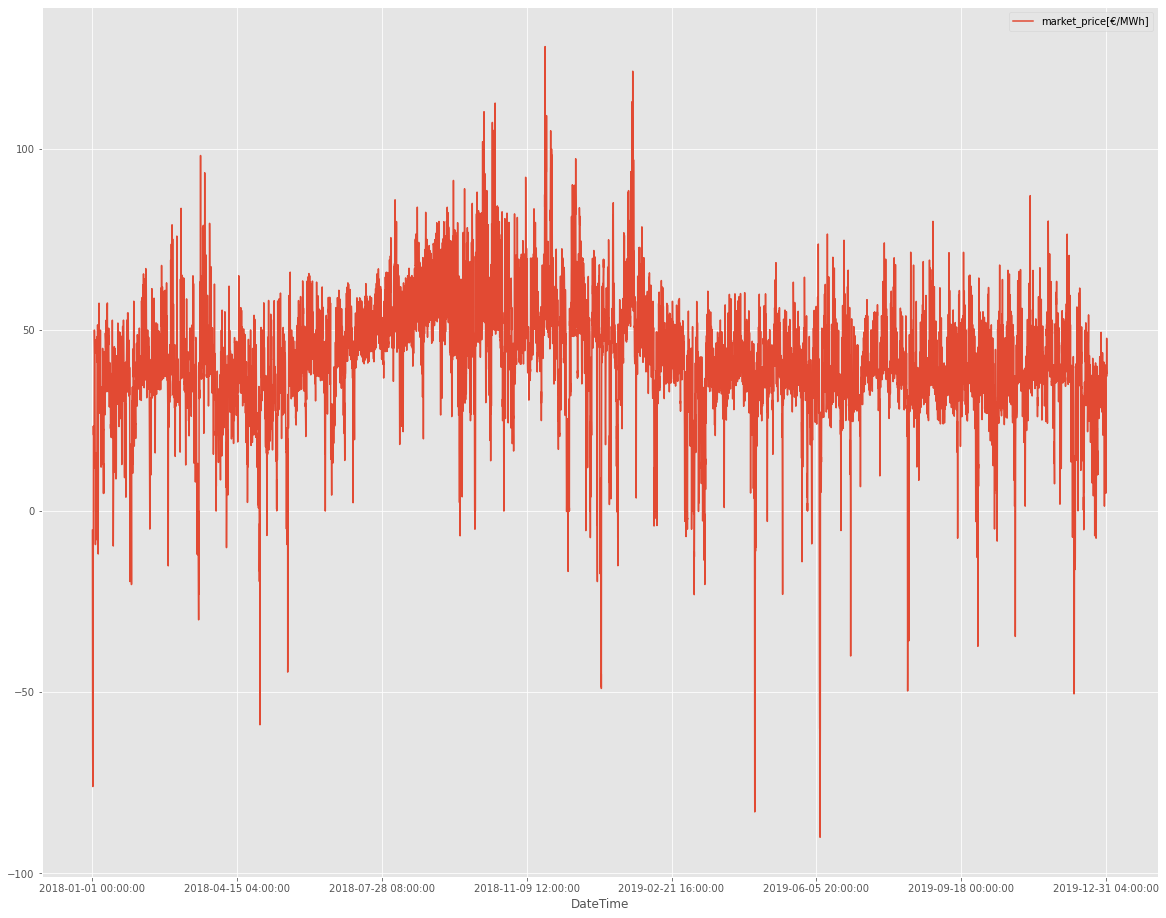

In [16]:
ax = prc_only.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Market price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [21]:
prediction = pred2.predicted_mean['2019-01-01':'2019-12-29'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2019 is {:.2f}%'.format(MAPE))#infinity was the outcome which didnt make sense

The Mean Absolute Percentage Error for the forecast of year 2019 is inf%
